# Линейная регрессия. Практическая работа.

Цель: предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

In [308]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [309]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

* age — возраст основного бенефициара;
* sex — пол страхового подрядчика;
* bmi — индекс массы тела (кг/м), в идеале — от 18.5 до 24.9;
* children — количество детей, охваченных медицинской страховкой;
* smoker — является ли человек курящим;
* region — жилой район США (северо-восток, юго-восток, северо-запад, юго-запад);
* charges (целевой признак) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

Размер таблицы:

In [310]:
print(data.shape)
# (1338, 7)

(1338, 7)


Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии:

In [311]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

Посмотрим на типы данных:

In [312]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

* age, bmi, children — числовые признаки;
* sex, smoker — бинарные категориальные переменные (две категории);
* region — множественные категориальные переменные (несколько категорий);
* charges — числовой целевой признак.

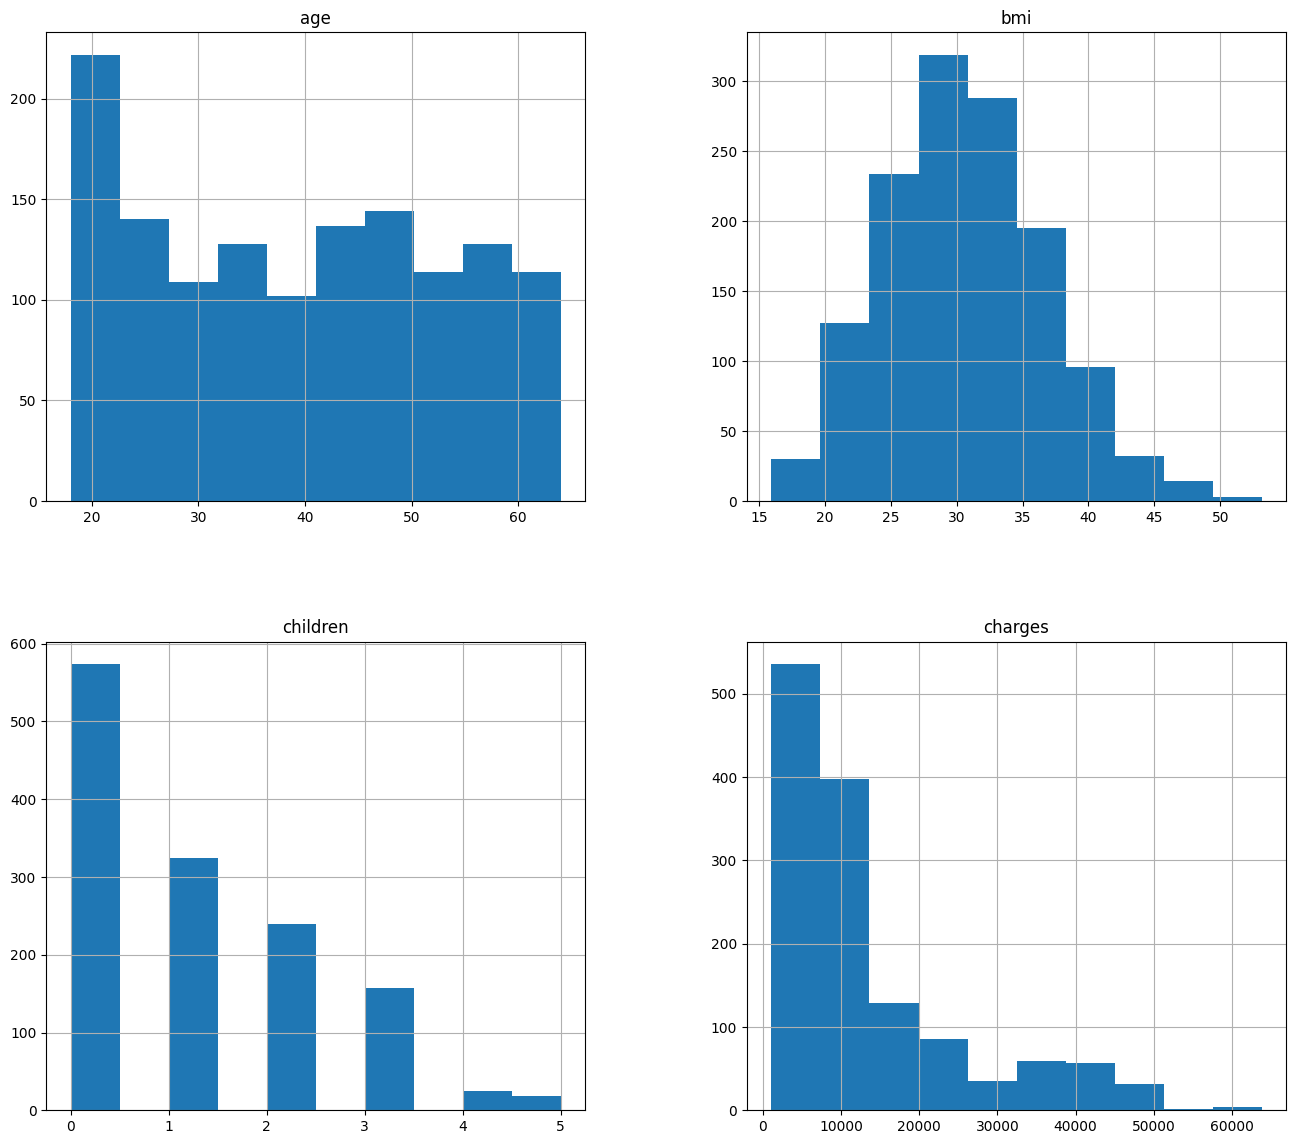

In [313]:
data.hist(figsize=(16,14));

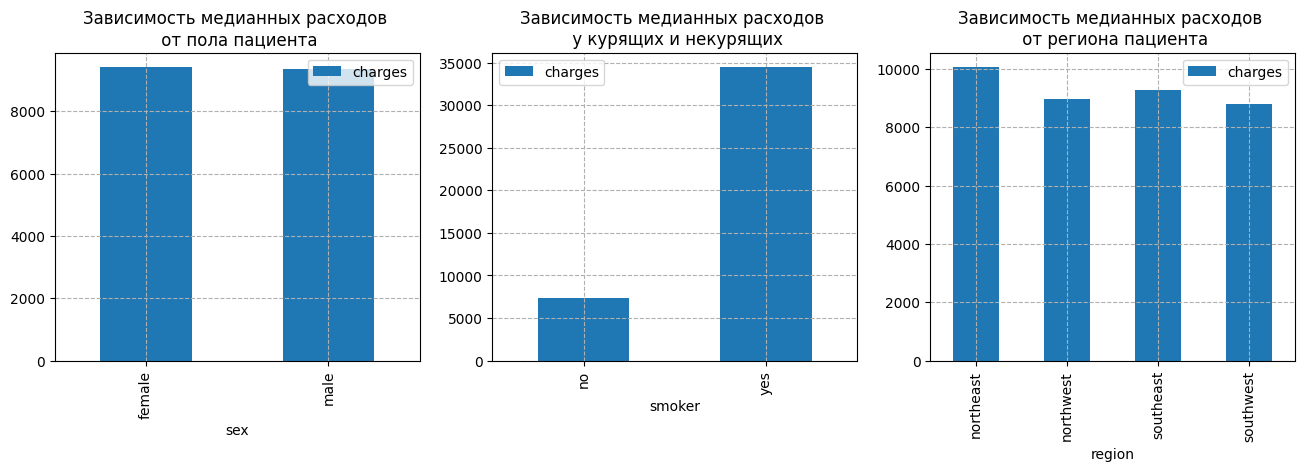

In [314]:

sex_group = data.groupby(['sex']).agg({'charges':'median'})
smoker_group = data.groupby(['smoker']).agg({'charges':'median'})
region_group = data.groupby(['region']).agg({'charges':'median'})

fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
bar1 = sex_group.plot(kind='bar', ax=axes[0])
bar1.set_title('Зависимость медианных расходов \n от пола пациента')
bar1.grid(ls='--')
bar2 = smoker_group.plot(kind='bar', ax=axes[1])
bar2.set_title('Зависимость медианных расходов \n у курящих и некурящих')
bar2.grid(ls='--')
bar3 = region_group.plot(kind='bar',ax=axes[2])
bar3.set_title('Зависимость медианных расходов \n от региона пациента')
bar3.grid(ls='--')



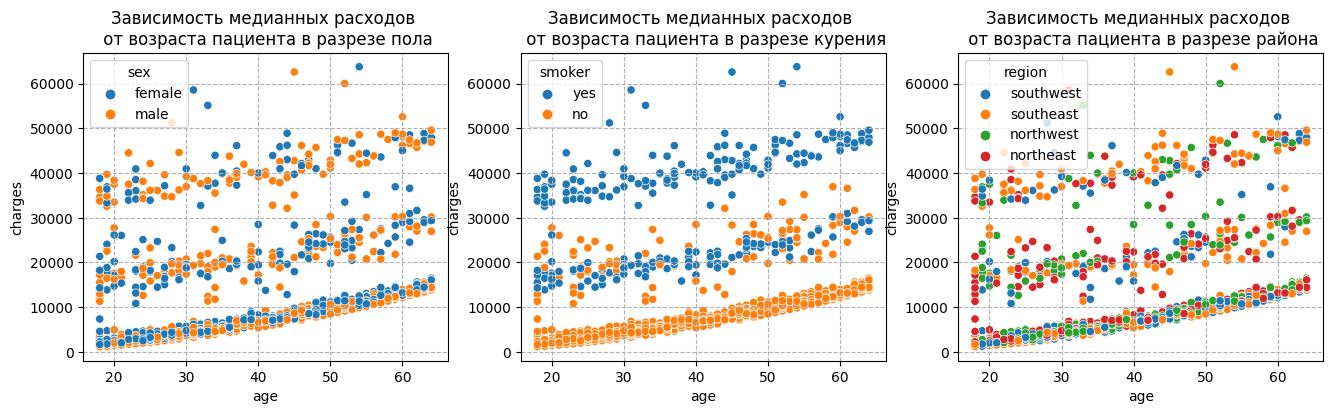

In [315]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
ax1 = sns.scatterplot(data=data, x='age', y='charges', hue='sex', ax=axes[0])
ax1.set_title('Зависимость медианных расходов \n от возраста пациента в разрезе пола')
ax1.grid(ls='--')
ax2 = sns.scatterplot(data=data, x='age', y='charges', hue='smoker', ax=axes[1])
ax2.set_title('Зависимость медианных расходов \n от возраста пациента в разрезе курения')
ax2.grid(ls='--')
ax3 = sns.scatterplot(data=data, x='age', y='charges', hue='region', ax=axes[2])
ax3.set_title('Зависимость медианных расходов \n от возраста пациента в разрезе района')
ax3.grid(ls='--')

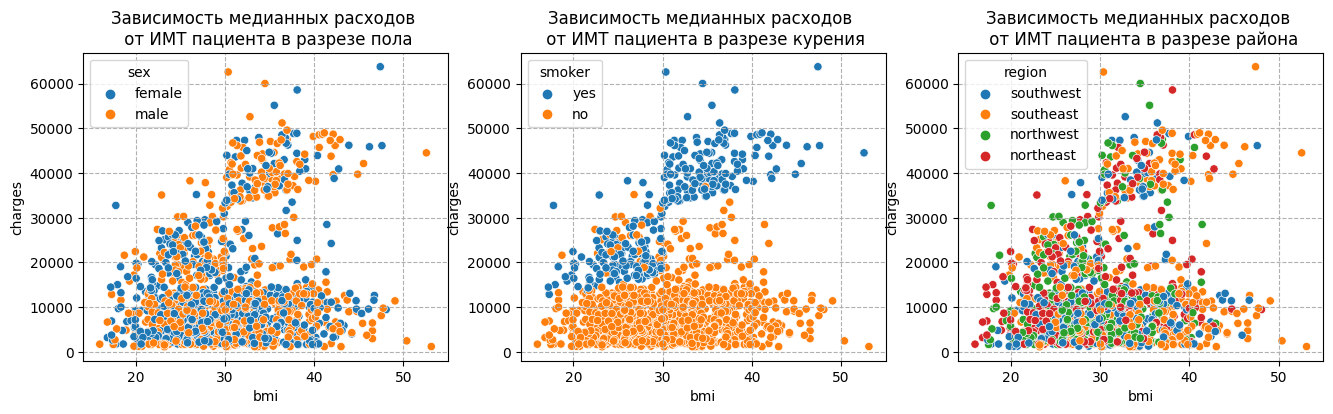

In [316]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))
ax1 = sns.scatterplot(data=data, x='bmi', y='charges', hue='sex', ax=axes[0])
ax1.set_title('Зависимость медианных расходов \n от ИМТ пациента в разрезе пола')
ax1.grid(ls='--')
ax2 = sns.scatterplot(data=data, x='bmi', y='charges', hue='smoker', ax=axes[1])
ax2.set_title('Зависимость медианных расходов \n от ИМТ пациента в разрезе курения')
ax2.grid(ls='--')
ax3 = sns.scatterplot(data=data, x='bmi', y='charges', hue='region', ax=axes[2])
ax3.set_title('Зависимость медианных расходов \n от ИМТ пациента в разрезе района')
ax3.grid(ls='--')

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

Кодировку будем совершать по следующему принципу:

* smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
* sex — аналогично (0 — female, 1 — male);
* region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [317]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

Выделим факторы и целевой признак в отдельные таблицы:

In [318]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

##### Задание 6.1

Прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделите набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуйтесь функцией train_test_split.
В качестве значения параметра random_state укажите число 42.
Чему равно количество наблюдений в тестовом наборе данных?

In [319]:
#X - матрица наблюдений, y - столбец правильных ответов
X = data.drop('charges', axis=1)
y = data['charges']

In [320]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


##### Задание 6.2

Обучите модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных. Все параметры оставьте по умолчанию. Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [321]:
#Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()
#Обучаем модель - ищем параметры
lr.fit(X_train, y_train)

print(np.round(lr.intercept_,2))

-12390.8


##### Задание 6.3

С помощью модели, полученной в предыдущем задании, сделайте предсказание на тренировочной и тестовой выборке. Рассчитайте следующие три метрики: $R^2$, $MAE$, $MAPE$. Не забудьте привести значение $MAPE$ к процентам.
Значение $R^2$ округлите до трёх знаков после точки-разделителя, а значения $MAE$ и $MAPE$ — до целого числа.

Чему равны значения метрик на тренировочной и тестовой выборках?

In [322]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.0f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('___________________')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.0f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Test MAPE: {:.0f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [323]:
#Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208
Train MAPE: 42
___________________
Test R^2: 0.784
Test MAE: 4181
Test MAPE: 47


##### Задание 6.4

Постройте диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках. В качестве ошибки возьмите разницу между истинным ответом и предсказанием: $y-\hat y$ (без модуля).


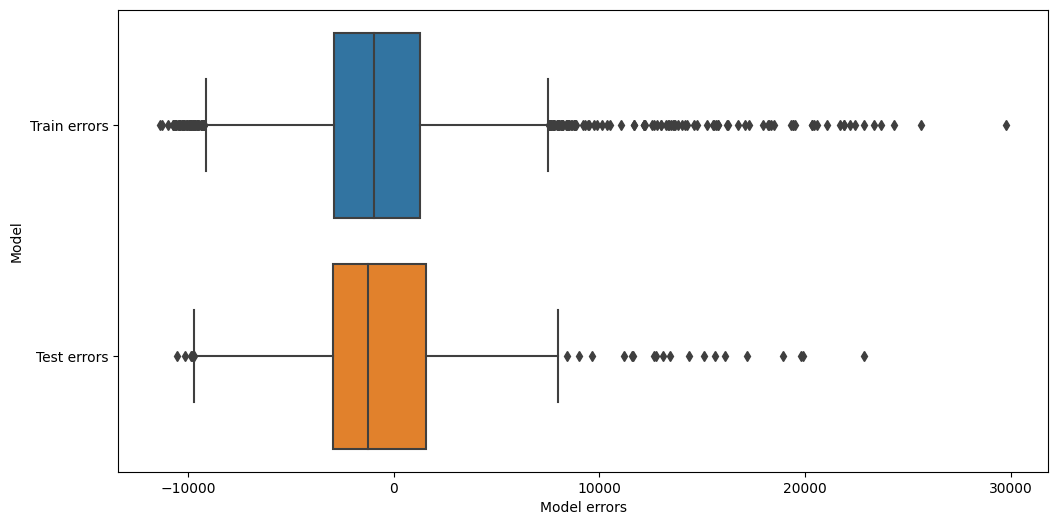

In [324]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 6)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax, orient='h')
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

##### Задание 6.5

Нормализуйте тренировочную и тестовую выборки с помощью min-max-нормализации (MinMaxScaler). Расчёт параметров нормализации (fit) произведите на тренировочной выборке.

Примечание. Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

На нормализованных данных сгенерируйте полиномиальные признаки степени 2. Воспользуйтесь классом PolynomialFeatures из библиотеки sklearn. Значение параметра include_bias выставите на False.

Чему равно результирующее количество столбцов?

In [325]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


##### Задание 6.6

Обучите модель линейной регрессии на полиномиальных признаках.

Чему равно значение метрики  на тестовой выборке?

Значение  округлите до трёх знаков после запятой.

In [326]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_predict = lr_poly.predict(X_train_scaled_poly)
y_test_predict = lr_poly.predict(X_test_scaled_poly)
print_metrics(y_train, y_train_predict, y_test, y_test_predict)

Train R^2: 0.842
Train MAE: 2898
Train MAPE: 30
___________________
Test R^2: 0.867
Test MAE: 2732
Test MAPE: 31


##### Задание 6.7

Выведите значения коэффициентов полученной модели. Посмотрите на степени коэффициентов.

Какой вывод можно сделать?

In [327]:
print(lr_poly.coef_)

[-1.12924931e+16  1.29293212e+17  5.28565156e+14  1.46077768e+15
  3.07370040e+15 -8.81138067e+15  3.18043528e+15 -3.33091960e+15
 -1.94389154e+14  8.51400000e+03  8.42500000e+02  1.13200000e+03
 -1.63550000e+03  1.66000000e+02  1.12924931e+16  1.12924931e+16
  1.12924931e+16  1.12924931e+16 -1.09115772e+17  6.83187500e+02
 -1.22237500e+03  2.84437500e+02 -2.01774399e+16 -2.01774399e+16
 -2.01774399e+16 -2.01774399e+16 -9.73190625e+03  1.57575000e+03
  5.48514141e+04 -5.28565156e+14 -5.28565156e+14 -5.28565156e+14
 -5.28565156e+14 -2.04000000e+03 -2.21500000e+03 -1.46077768e+15
 -1.46077768e+15 -1.46077768e+15 -1.46077768e+15 -6.50930025e+15
  3.43559985e+15  3.43559985e+15  3.43559985e+15  3.43559985e+15
  4.28151236e+15  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -7.71030359e+15  0.00000000e+00  0.00000000e+00 -1.19894871e+15
  0.00000000e+00 -4.33547915e+15]


##### Задание 6.8

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

Чему равны метрики $R^2$, $MAE$, $MAPE$ на тестовой выборке?

Значение $R^2$ округлите до трёх знаков после точки-разделителя, а значения $MAE$ и $MAPE$ — до целого числа.

In [330]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.842
Train MAE: 2890
Train MAPE: 29
___________________
Test R^2: 0.867
Test MAE: 2719
Test MAPE: 30


##### Задание 6.9

Постройте линейную регрессию с L2-регуляризацией на полиномиальных признаках. В качестве параметра alpha используйте значение по умолчанию.

Чему равны метрики $R^2$, $MAE$, $MAPE$ на тестовой выборке?

Значение $R^2$ округлите до трёх знаков после точки-разделителя, а значения $MAE$ и $MAPE$ — до целого числа.

In [332]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.839
Train MAE: 2949
Train MAPE: 30
___________________
Test R^2: 0.863
Test MAE: 2861
Test MAPE: 31
